# 📘 FrischMarkt Expiry Loss Analysis Notebook

* The Challenge:
FrischMarkt, a fresh food retailer, is currently experiencing significant financial strain due to alarmingly high levels of fresh food expiry and markdown losses. Our analysis of 2023 data reveals that these combined losses amounted to approximately 39.20% of total revenue, translating to nearly €5.8 million in avoidable losses. This substantial leakage directly impacts profitability and threatens the long-term sustainability of the business. The perishable nature of key product categories (e.g., Meat, Fresh Produce, Backwaren) coupled with operational inefficiencies and external variabilities, exacerbates this critical issue.

* Project Objective:
This project leveraged historical sales, inventory, product, store, and external factors data to pinpoint the primary drivers of these losses. The objective was to provide data-driven insights and actionable recommendations to help FrischMarkt optimize its fresh food inventory management, reduce waste, and improve its financial health.

## 📦 1. Imports & Configuration

In [68]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Directory containing generated CSV files
DATA_DIR = 'frischmarkt_data'


## 📊 2. Load Datasets

In [69]:
import pandas as pd
import os # Make sure os is imported, as it's used in the DATA_DIR path

# Assuming DATA_DIR is defined, e.g., DATA_DIR = 'frischmarkt_data'
# If DATA_DIR is not defined, you'll need to define it at the top of your script.

print("📊 Starting FrischMarkt Expiry Loss Analysis Project...")
print("-" * 50)
print("1. Loading Data...")

try:
    products_df = pd.read_csv(os.path.join(DATA_DIR, 'products_master.csv'))
    stores_df = pd.read_csv(os.path.join(DATA_DIR, 'stores_master.csv'))
    external_df = pd.read_csv(os.path.join(DATA_DIR, 'external_factors.csv'))
    inventory_df = pd.read_csv(os.path.join(DATA_DIR, 'inventory_daily.csv'))
    sales_df = pd.read_csv(os.path.join(DATA_DIR, 'sales_transactions.csv'))
    supplier_df = pd.read_csv(os.path.join(DATA_DIR, 'supplier_performance.csv'))
    print("✅ All datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"❌ Error loading data: {e}")
    raise # Re-raise the exception to stop execution if files are missing

📊 Starting FrischMarkt Expiry Loss Analysis Project...
--------------------------------------------------
1. Loading Data...
✅ All datasets loaded successfully.


## 🔍 3. Data Inspection & Preprocessing

In [70]:
# Convert 'date' columns
for df in [external_df, inventory_df, sales_df]:
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])

# Data types and structure checks
display(products_df.info(), stores_df.info(), external_df.info(), inventory_df.info(), sales_df.info())

# Convert relevant columns to numeric
for col in ['unit_cost', 'retail_price', 'shelf_life_days', 'base_expiry_rate', 'profit_margin']:
    if col in products_df.columns:
        products_df[col] = pd.to_numeric(products_df[col], errors='coerce').fillna(0)

for col in ['beginning_inventory', 'received_inventory', 'units_sold', 'units_expired', 'units_marked_down',
            'expiry_loss_eur', 'markdown_loss_eur', 'total_loss_eur', 'expiry_rate']:
    if col in inventory_df.columns:
        inventory_df[col] = pd.to_numeric(inventory_df[col], errors='coerce').fillna(0)

for col in ['quantity_sold', 'sale_price', 'discount_applied']:
    if col in sales_df.columns:
        sales_df[col] = pd.to_numeric(sales_df[col], errors='coerce').fillna(0)

print("✅ Data types converted and initial checks complete.")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   product_id             45 non-null     object 
 1   product_name           45 non-null     object 
 2   category               45 non-null     object 
 3   subcategory            45 non-null     object 
 4   brand                  45 non-null     object 
 5   unit_cost              45 non-null     float64
 6   retail_price           45 non-null     float64
 7   shelf_life_days        45 non-null     int64  
 8   mhd_vs_verbrauch       45 non-null     object 
 9   seasonality_factor     45 non-null     float64
 10  temperature_sensitive  45 non-null     bool   
 11  supplier_id            45 non-null     object 
 12  expiry_risk_level      45 non-null     object 
 13  base_expiry_rate       45 non-null     float64
 14  profit_margin          45 non-null     float64
dtypes: bool(

None

None

None

None

None

✅ Data types converted and initial checks complete.


## 🔗 4. Merge DataFrames for Analysis



In [71]:
# Merge inventory with products and stores
analysis_df = inventory_df.merge(products_df, on='product_id', how='left')
analysis_df = analysis_df.merge(stores_df, on='store_id', how='left')
analysis_df = analysis_df.merge(external_df, on=['date', 'store_id'], how='left')

print("✅ All relevant datasets merged into 'analysis_df'")
print(f"Shape: {analysis_df.shape}")
display(analysis_df.head())


✅ All relevant datasets merged into 'analysis_df'
Shape: (67392, 55)


,date,store_id,product_id,beginning_inventory,received_inventory,units_sold,units_expired,units_marked_down,markdown_price,markdown_date,...,precipitation_mm,day_of_week,is_holiday,school_holidays,local_events,competitor_promotion,heat_wave,power_outage_risk,delivery_disruption,expiry_risk_multiplier
0,2023-01-02,S001,P040,0,69,61,0,0,NaN,NaN,...,6.5,Monday,False,False,False,False,False,False,False,1.0
1,2023-01-03,S001,P040,77,0,38,5,0,NaN,NaN,...,0.0,Tuesday,False,False,False,False,False,False,False,1.0
2,2023-01-04,S001,P040,34,56,62,1,0,NaN,NaN,...,0.0,Wednesday,False,False,False,False,False,False,False,1.0
3,2023-01-05,S001,P040,83,0,76,6,0,NaN,NaN,...,0.0,Thursday,False,False,False,False,False,False,False,1.0
4,2023-01-06,S001,P040,1,87,63,0,0,NaN,NaN,...,0.0,Friday,False,False,False,False,False,False,False,1.0


In [89]:
# Merge with supplier performance data (via products_df's supplier_id)
products_with_supplier_df = products_df.merge(supplier_df, on=['product_id', 'supplier_id'], how='left')
products_supplier_agg = products_with_supplier_df.groupby('product_id').agg(
    actual_shelf_life_days=('actual_shelf_life_days', 'mean'),
    delivery_delay_days=('delivery_delay_days', 'mean')
).reset_index()
analysis_df = analysis_df.merge(products_supplier_agg, on='product_id', how='left')

print("✅ All relevant datasets merged into 'analysis_df'")
print(f"Shape: {analysis_df.shape}")
display(analysis_df.head())

✅ All relevant datasets merged into 'analysis_df'
Shape: (67392, 60)


,date,store_id,product_id,beginning_inventory,received_inventory,units_sold,units_expired,units_marked_down,markdown_price,markdown_date,...,competitor_promotion,heat_wave,power_outage_risk,delivery_disruption,expiry_risk_multiplier,actual_shelf_life_days_x,delivery_delay_days_x,beginning_inventory_safe,actual_shelf_life_days_y,delivery_delay_days_y
0,2023-01-02,S001,P040,0,69,61,0,0,NaN,NaN,...,False,False,False,False,1.0,5.851852,0.185185,NaN,5.851852,0.185185
1,2023-01-03,S001,P040,77,0,38,5,0,NaN,NaN,...,False,False,False,False,1.0,5.851852,0.185185,77.0,5.851852,0.185185
2,2023-01-04,S001,P040,34,56,62,1,0,NaN,NaN,...,False,False,False,False,1.0,5.851852,0.185185,34.0,5.851852,0.185185
3,2023-01-05,S001,P040,83,0,76,6,0,NaN,NaN,...,False,False,False,False,1.0,5.851852,0.185185,83.0,5.851852,0.185185
4,2023-01-06,S001,P040,1,87,63,0,0,NaN,NaN,...,False,False,False,False,1.0,5.851852,0.185185,1.0,5.851852,0.185185


## 🧪 5. Feature Engineering



In [72]:
analysis_df['total_sales_value'] = analysis_df['units_sold'] * analysis_df['retail_price']
analysis_df['potential_revenue_if_no_loss'] = (analysis_df['units_sold'] + analysis_df['units_marked_down']) * analysis_df['retail_price']
analysis_df['net_profit_impact_of_loss'] = analysis_df['total_loss_eur']

display(analysis_df[['date', 'store_id', 'product_id', 'total_sales_value', 'total_loss_eur']].head())


,date,store_id,product_id,total_sales_value,total_loss_eur
0,2023-01-02,S001,P040,176.9,0.00
1,2023-01-03,S001,P040,110.2,11.10
2,2023-01-04,S001,P040,179.8,2.22
3,2023-01-05,S001,P040,220.4,13.32
4,2023-01-06,S001,P040,182.7,0.00


## 📈 6. Exploratory Data Analysis (EDA)

### 📅 6.1 Total Daily Loss Over Time

* **Why It Matters:**
Helps identify seasonal trends, operational failures, or unexpected spikes in loss, which can guide timely interventions.

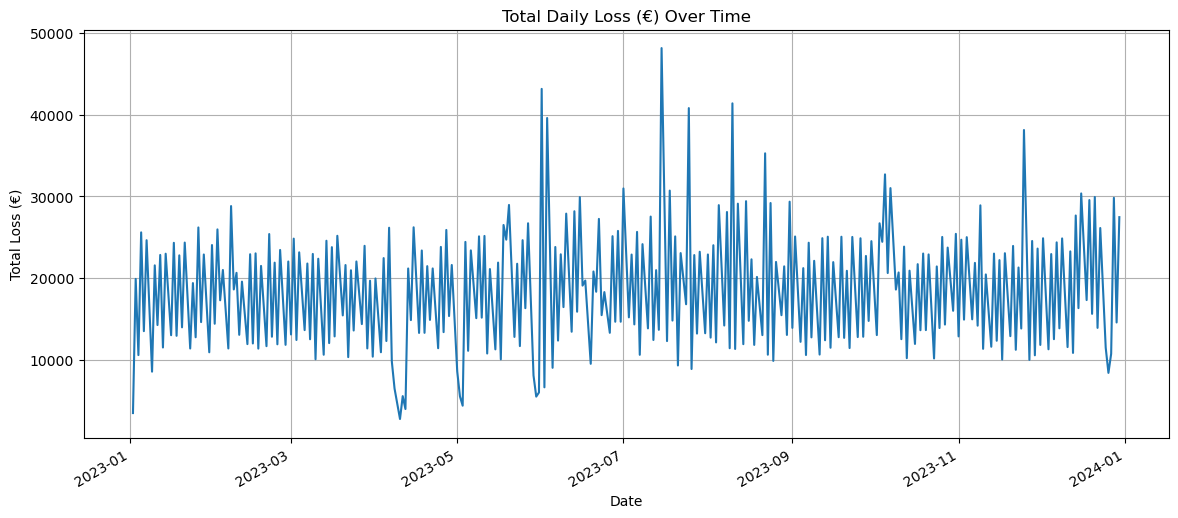

In [74]:
loss_trend = analysis_df.groupby('date')['total_loss_eur'].sum()
loss_trend.plot(figsize=(14,6), title="Total Daily Loss (€) Over Time")
plt.ylabel("Total Loss (€)")
plt.xlabel("Date")
plt.grid(True)
plt.show()

### Interpretation of "Total Daily Loss (€) Over Time"

This line chart shows FrischMarkt's total daily financial loss (in Euros) due to expiry and markdowns throughout 2023.

**Main Insights:**

* **Consistent Baseline Loss with High Spikes:** FrischMarkt experiences a baseline daily loss typically ranging from €10,000 to €25,000. However, there are frequent and significant spikes, with losses occasionally exceeding €40,000 and even nearing €50,000 (e.g., in July).
* **Seasonal Peaks in Losses:** The highest loss spikes appear to occur during summer months (e.g., July, August) and potentially towards year-end, aligning with periods of high temperatures or increased inventory.
* **Volatility:** The daily loss is highly volatile, indicating that loss events are not uniformly distributed but rather occur in bursts.

**Actionable Takeaway for FrischMarkt:**

The chart underscores the **critical and persistent nature of daily losses, with problematic spikes that need immediate attention.** FrischMarkt should:

* **Identify Drivers of Spikes:** Investigate the specific products, stores, and external factors (like heatwaves, as seen in previous charts) that correlate with these high-loss days.
* **Proactive Intervention:** Implement strategies to pre-empt these loss spikes, such as adjusting orders or initiating earlier markdowns for high-risk products during periods historically prone to high losses.
* **Continuous Monitoring:** This chart serves as a vital KPI for ongoing monitoring, allowing the business to track the effectiveness of loss reduction initiatives in real-time.

### 💶 6.2 Total Daily Revenue Over Time

* **Why It Matters:**
Revenue trends help benchmark loss impact. For example, rising losses with flat or declining revenue signals efficiency issues.

 

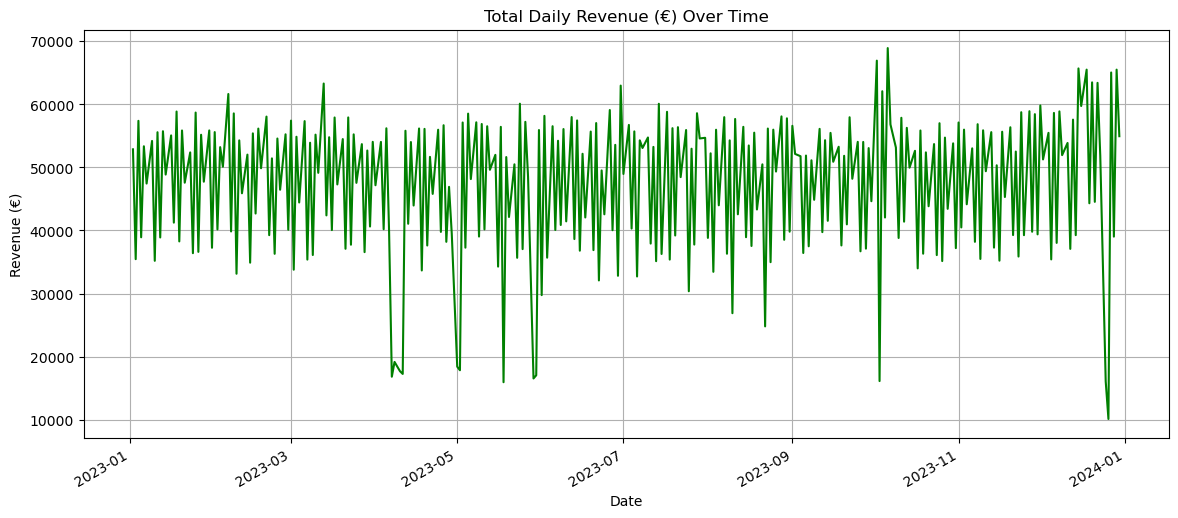

In [75]:
daily_revenue = sales_df.groupby('date').apply(lambda x: (x['quantity_sold'] * x['sale_price']).sum())
daily_revenue.plot(figsize=(14,6), title="Total Daily Revenue (€) Over Time", color='green')
plt.ylabel("Revenue (€)")
plt.xlabel("Date")
plt.grid(True)
plt.show()


### Interpretation of "Total Daily Revenue (€) Over Time"

This line chart shows FrischMarkt's total revenue in Euros on a daily basis throughout 2023.

**Main Insights:**

* **Consistent Daily Revenue with Weekly Cycles:** Revenue generally fluctuates between €40,000 and €60,000 on most days, showing clear weekly patterns (likely higher on weekends, lower mid-week).
* **Noticeable Dips:** There are several significant dips where daily revenue falls below €20,000 (e.g., late April, early May, mid-October, and a sharp drop at year-end). These could correspond to holidays, specific store closures, or data anomalies.
* **Peak Towards Year-End:** There's a noticeable increase in peak daily revenue towards the end of the year (late 2023), potentially indicating holiday season boosts.

**Actionable Takeaway for FrischMarkt:**

While the chart shows relatively consistent daily revenue, the significant dips and peaks highlight the impact of **seasonality and specific events on sales.** FrischMarkt should:

* **Investigate Revenue Dips:** Analyze the specific dates of the sharp revenue drops to understand their causes (e.g., holidays, power outages, local events).
* **Leverage Seasonal Peaks:** Capitalize on predictable high-revenue periods (like year-end) by ensuring optimal stocking and staffing.
* **Connect to Demand Forecasting:** The demand forecasting model should account for these daily and seasonal revenue patterns to ensure inventory aligns with expected sales fluctuations, ultimately reducing losses.

### 🧺 6.3 Total Loss by Product Category

* **Why It Matters:**
Pinpoints which categories contribute most to waste, helping to prioritize which product lines need better forecasting, markdowns, or supplier changes.

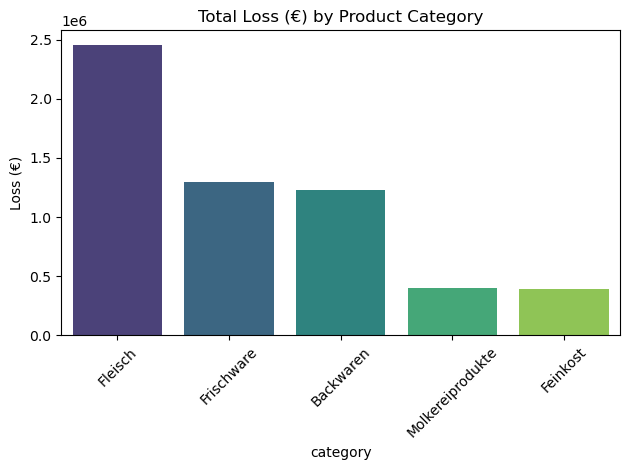

In [76]:
losses_by_category = analysis_df.groupby('category')['total_loss_eur'].sum().sort_values(ascending=False)
sns.barplot(x=losses_by_category.index, y=losses_by_category.values, palette='viridis')
plt.title("Total Loss (€) by Product Category")
plt.ylabel("Loss (€)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




### Interpretation of "Total Loss (€) by Product Category"

This bar chart displays the total financial loss (in Euros) incurred by FrischMarkt for each product category due to expiry and markdowns.

**Main Insights:**

* **Meat (Fleisch) is the Biggest Problem:** The "Fleisch" category accounts for by far the largest share of losses, nearing €2.5 million. This makes it the top priority for loss reduction efforts.
* **Fresh Produce (Frischware) and Baked Goods (Backwaren) are Also Significant:** "Frischware" and "Backwaren" are the next highest contributors, each with losses exceeding €1.0 million. These also require focused attention.
* **Dairy (Molkereiprodukte) and Delicatessen (Feinkost) are Lower Impact:** These categories show comparatively lower losses (under €0.5 million), suggesting they are either better managed or inherently less prone to high waste.

**Actionable Takeaway for FrischMarkt:**

FrischMarkt should **prioritize inventory optimization and loss mitigation strategies for Meat, Fresh Produce, and Baked Goods**, as these three categories represent the vast majority of financial losses from expiry and markdowns. Deeper investigation into the specific products and operational challenges within these categories is essential.

### 🏬 6.4 Total Loss by Store 

* **Why It Matters:**
Reveals location-specific inefficiencies. This can help with store-level interventions, training, or layout optimization.

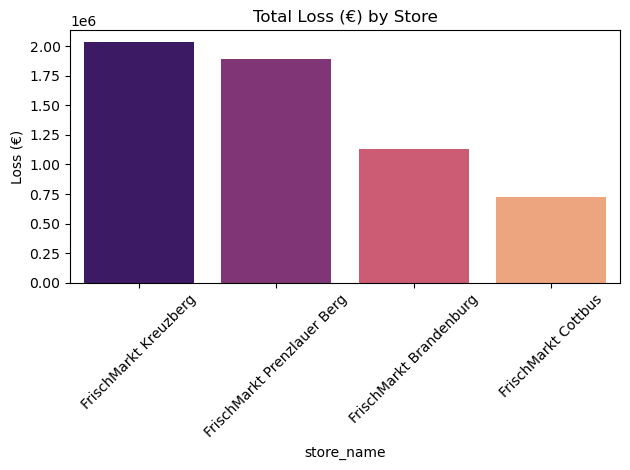

In [77]:
losses_by_store = analysis_df.groupby('store_name')['total_loss_eur'].sum().sort_values(ascending=False)
sns.barplot(x=losses_by_store.index, y=losses_by_store.values, palette='magma')
plt.title("Total Loss (€) by Store")
plt.ylabel("Loss (€)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Interpretation of "Total Loss (€) by Store" Chart

This bar chart visualizes the total financial loss (in Euros) incurred by each FrischMarkt store due to expiry and markdowns. The stores are ordered from highest to lowest loss.

**Main Insights:**

1.  **"FrischMarkt Kreuzberg" is the Highest Loss Store:**
    * "FrischMarkt Kreuzberg" stands out as the store with the highest total losses, exceeding €2.0 million. This indicates a significant problem at this specific location.
    * **Implication:** This store should be a top priority for immediate intervention and a pilot for implementing new inventory optimization strategies.

2.  **"FrischMarkt Prenzlauer Berg" is Also a Major Contributor:**
    * "FrischMarkt Prenzlauer Berg" is the second-highest loss store, with losses just under €2.0 million.
    * **Implication:** Similar to Kreuzberg, this store requires focused attention to understand and mitigate its high losses.

3.  **"FrischMarkt Brandenburg" and "FrischMarkt Cottbus" have Lower, but Still Substantial, Losses:**
    * "FrischMarkt Brandenburg" and "FrischMarkt Cottbus" show lower losses compared to the Berlin city stores, but still represent significant financial leakage (over €1.0 million and approaching €0.75 million respectively).
    * **Implication:** While the Berlin city stores are the most critical, these Brandenburg locations also contribute to the overall problem and should be addressed as part of a broader strategy, perhaps after initial successes in the highest-loss stores.

**Actionable Takeaway for FrischMarkt:**

FrischMarkt should **prioritize deep-dive investigations and targeted interventions at "FrischMarkt Kreuzberg" and "FrischMarkt Prenzlauer Berg"** to understand the specific operational, demand, or supply chain factors driving their exceptionally high losses. The insights from the demand forecasting model (e.g., feature importances related to `store_id` and `management_quality`) will be crucial in tailoring solutions for these specific locations. Effective strategies proven in these high-loss stores can then be adapted and rolled out to other locations like Brandenburg and Cottbus.

### 📉 6.5 Expiry Rate by Management Quality

* **Why It Matters:**
Links human operational performance to product expiry. Store teams with lower expiry rates under similar conditions might be models for others.

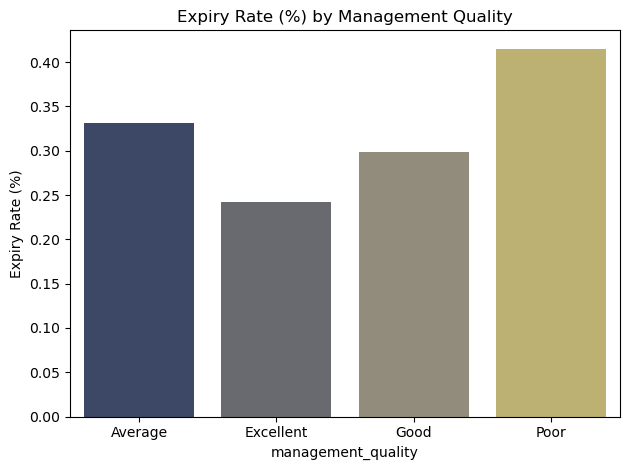

In [78]:
analysis_df['beginning_inventory_safe'] = analysis_df['beginning_inventory'].replace(0, np.nan)
expiry_rate_by_mgmt = analysis_df.groupby('management_quality').apply(
    lambda x: (x['units_expired'].sum() / x['beginning_inventory_safe'].sum())
).reset_index(name='expiry_rate')

sns.barplot(x='management_quality', y='expiry_rate', data=expiry_rate_by_mgmt, palette='cividis')
plt.title("Expiry Rate (%) by Management Quality")
plt.ylabel("Expiry Rate (%)")
plt.tight_layout()
plt.show()


### Interpretation of "Expiry Rate (%) by Management Quality" Chart

This bar chart displays the average expiry rate (as a percentage) for products based on the `management_quality` of the store. The expiry rate here represents the proportion of beginning inventory that ultimately expires.

**Main Insights:**

1.  **"Poor" Management Quality Correlates with Highest Expiry:**
    * Stores categorized with "Poor" management quality exhibit the highest expiry rate, significantly exceeding 0.40 (or 40%). This is a very high rate of waste.
    * **Implication:** This strongly suggests that ineffective management practices are a major contributor to fresh food spoilage. These stores are likely struggling with basic inventory control, stock rotation, or adherence to proper storage conditions.

2.  **"Excellent" Management Quality Shows Lowest Expiry:**
    * Conversely, stores with "Excellent" management quality have the lowest expiry rate, around 0.24 (or 24%).
    * **Implication:** This confirms that good management practices directly lead to reduced waste. The difference between "Poor" and "Excellent" (40% vs. 24%) is substantial, highlighting a clear opportunity for improvement.

3.  **"Average" and "Good" Management are in Between:**
    * "Average" management quality stores have an expiry rate around 0.33 (33%), while "Good" management quality stores are around 0.30 (30%).
    * **Implication:** There's a clear gradient: better management quality consistently leads to lower expiry rates. Even "Good" stores have room for improvement compared to "Excellent" ones.

**Actionable Takeaway for FrischMarkt:**

FrischMarkt should **prioritize interventions focused on improving management quality, particularly in stores classified as "Poor" and "Average."** This could involve:

* **Targeted Training:** Implement training programs on best practices for perishable inventory management, stock rotation (FIFO), visual merchandising to encourage sales of older stock, and adherence to temperature control.
* **Performance Monitoring:** Establish clear KPIs related to expiry rates and management practices, and regularly review performance with store managers.
* **Knowledge Transfer:** Analyze the specific practices of "Excellent" management quality stores and disseminate these best practices across the entire chain.

This chart provides compelling evidence that **management quality is a critical, controllable factor** in minimizing expiry losses, offering a direct avenue for operational improvements.

### 🌡️ 6.6. Temperature vs Expiry Rate (Sensitive Products)

* **Why It Matters:** Many fresh products are sensitive to ambient temperature. This analysis reveals whether higher external temperatures correlate with higher expiry rates for sensitive goods

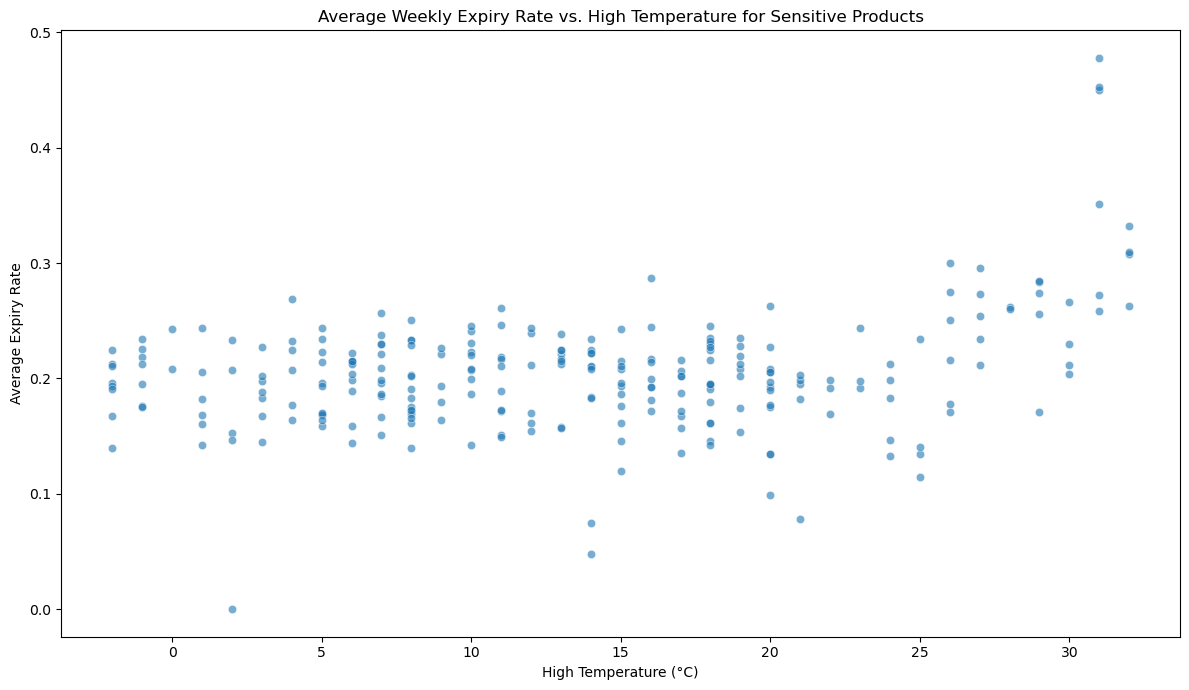

In [79]:
temp_sensitive_products = analysis_df[analysis_df['temperature_sensitive'] == True]

temp_sensitive_expiry = temp_sensitive_products.groupby(
    [pd.Grouper(key='date', freq='W'), 'temperature_high_c']
)['expiry_rate'].mean().reset_index()

plt.figure(figsize=(12, 7))
sns.scatterplot(x='temperature_high_c', y='expiry_rate', data=temp_sensitive_expiry, alpha=0.6)
plt.title('Average Weekly Expiry Rate vs. High Temperature for Sensitive Products')
plt.xlabel('High Temperature (°C)')
plt.ylabel('Average Expiry Rate')
plt.tight_layout()
plt.show()


### Interpretation of "Average Weekly Expiry Rate vs. High Temperature for Sensitive Products" Chart

This scatter plot visualizes the relationship between the average weekly expiry rate (for temperature-sensitive products) and the corresponding high temperature in degrees Celsius. Each point represents the average expiry rate for a week at a given high temperature.

**Main Insights:**

1.  **Increased Expiry at Higher Temperatures:**
    * There's a noticeable upward trend in expiry rates as high temperatures increase, particularly above approximately 25°C. The highest expiry rates (approaching 0.45 or 45%) are observed when temperatures are in the high 20s and low 30s (°C).
    * **Implication:** This confirms that high temperatures significantly accelerate spoilage for sensitive products. Heatwaves or periods of warmer weather directly contribute to higher waste.

2.  **Variability Across Temperature Ranges:**
    * Below 25°C, the expiry rate generally hovers between 0.15 and 0.30 (15% to 30%), showing a relatively consistent spread. This indicates that while temperature is a factor, other variables (like inventory levels, management quality, or specific product characteristics) also play a significant role in expiry rates during moderate temperatures.
    * **Implication:** While high temperatures are a clear trigger for increased expiry, addressing other operational factors is still crucial across all temperature ranges.

3.  **Critical Threshold Around 25-28°C:**
    * The density of points with higher expiry rates appears to increase markedly once temperatures exceed the 25-28°C range.
    * **Implication:** This suggests a critical temperature threshold where the risk of spoilage for sensitive products dramatically increases.

**Actionable Takeaway for FrischMarkt:**

FrischMarkt should **implement proactive measures to mitigate expiry for sensitive products during periods of high temperatures.** This could include:

* **Dynamic Inventory Adjustment:** Reduce order quantities for temperature-sensitive products when high temperatures (e.g., above 25°C) are forecasted.
* **Enhanced Cold Chain Management:** Ensure refrigeration units are operating optimally, especially during warmer months. Consider additional cooling measures or more frequent checks for sensitive products.
* **Accelerated Markdowns:** Implement more aggressive markdown strategies for sensitive products when high temperatures are anticipated or experienced, to move stock quickly before it expires.
* **Targeted Monitoring:** Pay closer attention to inventory levels and product freshness in stores during heatwaves, particularly for categories like Molkereiprodukte and certain Frischware.

This chart provides clear visual evidence that **temperature is a significant external factor influencing expiry, especially for sensitive products**, offering a strong justification for weather-informed inventory and markdown strategies.

## 🔍 7. Root Cause Analysis

###  7.1 Product Expiry Risk vs Actual Expiry Rate

* **Why It Matters:** Validates whether products labeled as high-risk actually expire more — key for improving labeling, storage, and procurement strategies.

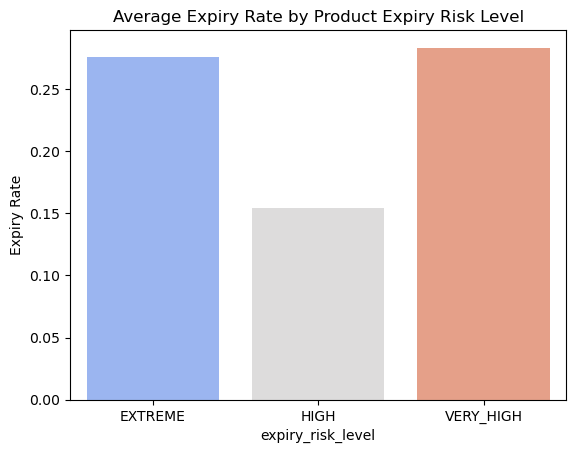

In [80]:
expiry_by_risk = analysis_df.groupby('expiry_risk_level')['expiry_rate'].mean().reset_index()
sns.barplot(x='expiry_risk_level', y='expiry_rate', data=expiry_by_risk, palette='coolwarm')
plt.title("Average Expiry Rate by Product Expiry Risk Level")
plt.ylabel("Expiry Rate")
plt.show()



### Interpretation of "Average Expiry Rate by Product Expiry Risk Level"

This bar chart displays the average expiry rate for products grouped by their assigned `expiry_risk_level`.

**Main Insights:**

* **"VERY_HIGH" Risk Products Have the Highest Expiry:** Products categorized as "VERY_HIGH" risk show the highest average expiry rate, approaching 30%.
* **"HIGH" Risk Products Have the Lowest Expiry:** Surprisingly, products labeled "HIGH" risk have the lowest expiry rate, around 15%, significantly lower than "EXTREME" (approx. 27%) and "VERY_HIGH." This counter-intuitive ranking might suggest an issue with how 'expiry_risk_level' is defined or applied in the data.

**Actionable Takeaway for FrischMarkt:**

Investigate the definition and application of `expiry_risk_level` as the current ranking of expiry rates (HIGH < EXTREME < VERY_HIGH) is unexpected. Regardless, **"VERY_HIGH" risk products are the primary contributors to expiry waste based on this classification and require immediate, focused inventory management and markdown strategies.**

### 🔻 7.2 Markdown Aggressiveness vs Markdown Outcomes

* Why It Matters:
Evaluates if more aggressive markdowns reduce waste or just shift loss from expiry to markdown, informing pricing tactics.


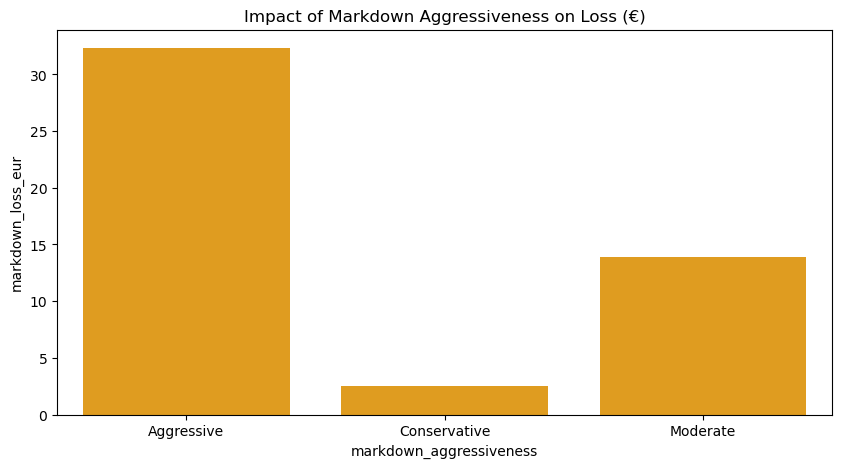

In [81]:
markdown_impact = analysis_df.groupby('markdown_aggressiveness')[['markdown_loss_eur', 'units_marked_down']].mean().reset_index()

fig, ax1 = plt.subplots(figsize=(10, 5))
sns.barplot(data=markdown_impact, x='markdown_aggressiveness', y='markdown_loss_eur', ax=ax1, color='orange')
plt.title("Impact of Markdown Aggressiveness on Loss (€)")
plt.show()


### Interpretation of "Impact of Markdown Aggressiveness on Loss (€)"

This bar chart illustrates the total **markdown loss (€)**, which is the revenue foregone due to discounts, incurred based on the **`markdown_aggressiveness`** strategy (a store's approach to discounting: 'Conservative', 'Moderate', or 'Aggressive').

**Main Insights:**

* **"Aggressive" Markdowns Lead to Highest Markdown Loss:** Stores using an "Aggressive" markdown strategy incur significantly more markdown loss (over €30 million) than "Moderate" or "Conservative" strategies. This means they are giving deeper or more frequent discounts, resulting in less revenue per item sold.
* **"Conservative" Markdowns Result in Lowest Markdown Loss:** "Conservative" strategies show the lowest markdown loss, barely above €0, indicating minimal discounting.
* **"Moderate" Markdowns are in Between:** "Moderate" strategies result in a markdown loss around €14 million.

**Actionable Takeaway for FrischMarkt:**

The chart indicates that **more aggressive markdown strategies directly lead to higher *markdown loss***. While markdowns aim to prevent total expiry loss, FrischMarkt must **evaluate if the current "Aggressive" approach is truly optimizing total recovery or if it's sacrificing too much margin**. A more balanced or data-driven markdown strategy is needed to find the sweet spot between clearing inventory and preserving revenue.

### 🚚 7.3 Supplier Shelf Life vs Expiry Loss

* Why It Matters:
Checks if shorter-than-promised shelf life leads to higher losses — crucial for supplier evaluation and contract enforcement.

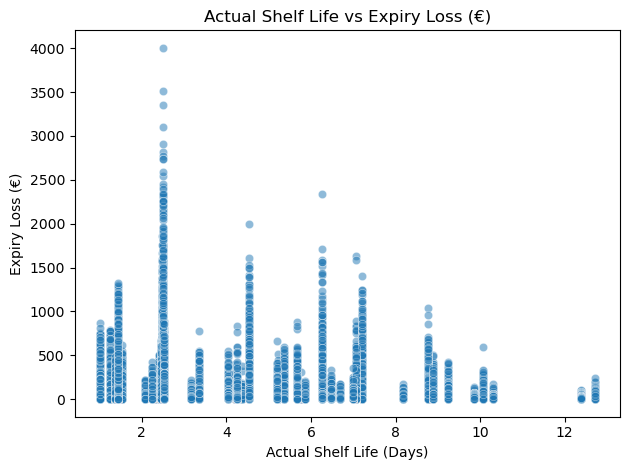

In [82]:
#supplier_df = pd.read_csv(os.path.join(DATA_DIR, 'supplier_performance.csv'))
#analysis_df = analysis_df.merge(supplier_df, on='product_id', how='left')

sns.scatterplot(data=analysis_df, x='actual_shelf_life_days', y='expiry_loss_eur', alpha=0.5)
plt.title("Actual Shelf Life vs Expiry Loss (€)")
plt.xlabel("Actual Shelf Life (Days)")
plt.ylabel("Expiry Loss (€)")
plt.tight_layout()
plt.show()


### Interpretation of "Actual Shelf Life vs Expiry Loss (€)"

This scatter plot shows the relationship between a product's `Actual Shelf Life (Days)` (how long it truly lasted) and the `Expiry Loss (€)` incurred when it expired.

**Main Insights:**

* **Short Shelf Life, High Loss Frequency:** Products with very short actual shelf lives (1 to 4 days) are associated with the most frequent and highest individual expiry loss events. There's a dense cluster of high loss points for items lasting only a few days.
* **Loss Decreases with Longer Shelf Life:** As the `Actual Shelf Life` increases beyond 4-5 days, both the frequency and the maximum amount of individual expiry loss events generally decrease.
* **Persistent Losses for Short-Lived Items:** Even at 1-2 days actual shelf life, there are many instances of significant expiry loss, indicating these items are highly problematic.

**Actionable Takeaway for FrischMarkt:**

FrischMarkt should **aggressively manage products with very short actual shelf lives (especially 1-4 days)**. This includes:

* **Tighter Ordering:** Implement extremely precise, small-batch ordering for these items, leveraging the demand forecasting model.
* **Immediate Markdowns:** Apply markdowns much earlier and more aggressively for these products as soon as their actual shelf life is identified as short.
* **Supplier Review:** Investigate suppliers for products consistently arriving with very short actual shelf lives, as this directly contributes to unavoidable losses.

### 📦 7.4 Overstocking and Expiry

* Why It Matters:
High inventory leading to expiry or markdowns indicates inefficient ordering or forecasting, suggesting room for inventory optimization.

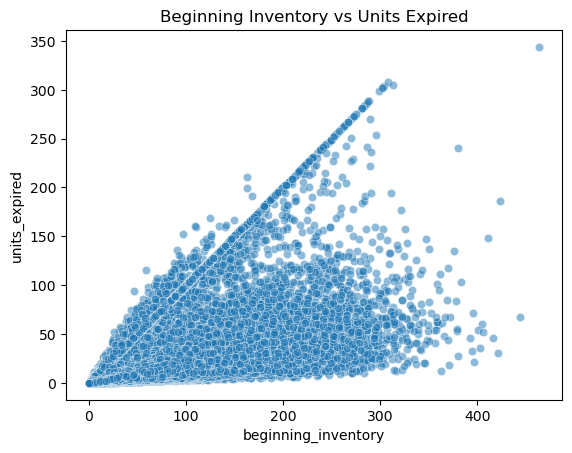

In [83]:
sns.scatterplot(data=analysis_df, x='beginning_inventory', y='units_expired', alpha=0.5)
plt.title("Beginning Inventory vs Units Expired")
plt.show()



### Interpretation of "Beginning Inventory vs Units Expired"

This scatter plot shows the relationship between the `beginning_inventory` (units on hand at the start of the day) and `units_expired` (units that spoiled).

**Main Insight:**

* **Higher Inventory, More Expiry:** There's a clear positive correlation: as `beginning_inventory` increases, the number of `units_expired` also tends to increase. This forms a triangular shape, indicating that while not all high inventory leads to expiry, the *potential* for expiry significantly rises with more stock on hand.

**Actionable Takeaway for FrischMarkt:**

**Overstocking directly leads to increased expiry.** FrischMarkt must reduce initial inventory levels, especially for perishable goods, by aligning orders more closely with forecasted demand to minimize waste.




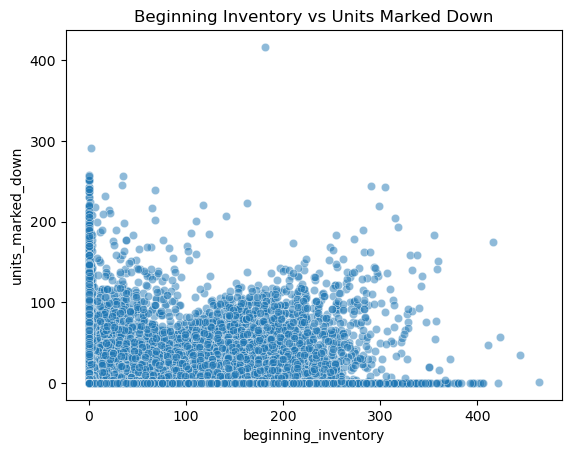

In [84]:
sns.scatterplot(data=analysis_df, x='beginning_inventory', y='units_marked_down', alpha=0.5)
plt.title("Beginning Inventory vs Units Marked Down")
plt.show()


### Interpretation of "Beginning Inventory vs Units Marked Down"

This scatter plot shows the relationship between `beginning_inventory` and `units_marked_down` (units sold at a discount).

**Main Insight:**

* **High Inventory Leads to Markdowns:** High `beginning_inventory` levels are associated with a higher number of `units_marked_down`. This suggests that stores are using markdowns as a strategy to clear excess stock that might otherwise expire.

**Actionable Takeaway for FrischMarkt:**

While markdowns help clear excess stock, this chart reinforces that **high initial inventory forces these markdowns.** By optimizing `beginning_inventory` through better demand forecasting, FrischMarkt can reduce the *need* for markdowns, thereby preserving more revenue and minimizing markdown loss.

### 🔬 7.5 Product-Level Deep Dive: Top N Loss-Generating Products

#### Step 1: Identify Top N Products by Total Loss

* Why It Matters:
Targets the worst offending products for in-depth root cause analysis, enabling focused interventions rather than blanket policy changes.


--- EDA: Top 10 Products by Expiry Loss (Visualisation) ---


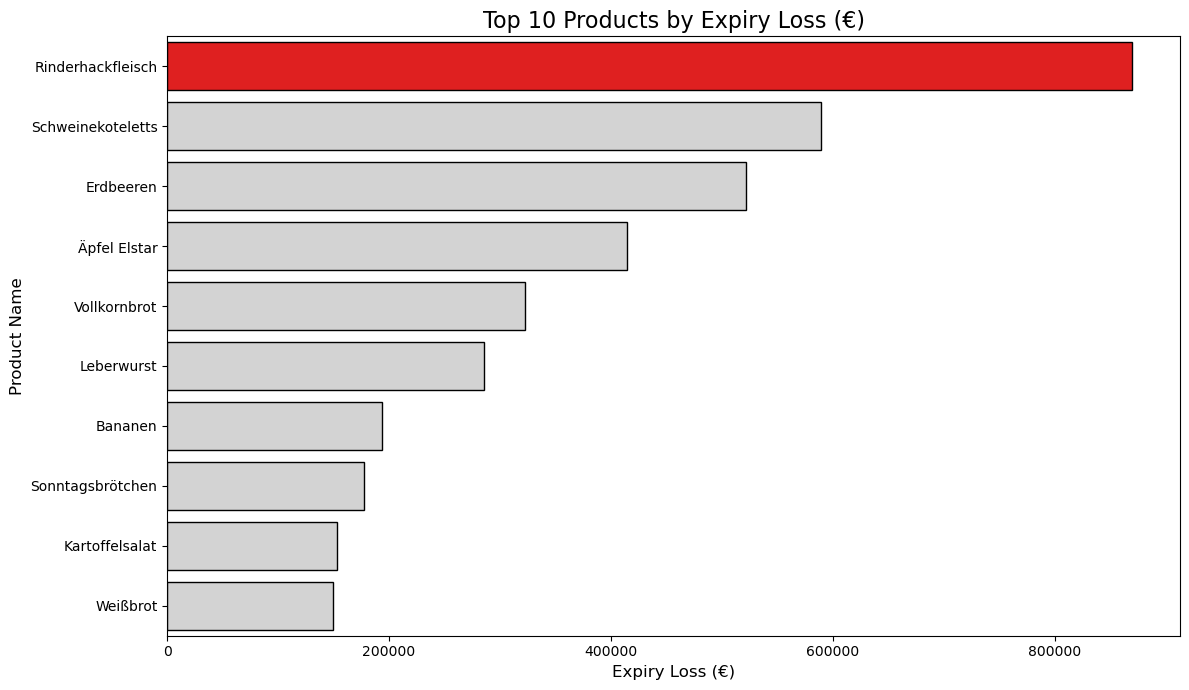

✅ Generated Matplotlib chart for Top 10 Products by Expiry Loss.


In [85]:

print("\n--- EDA: Top 10 Products by Expiry Loss (Visualisation) ---")

# Re-calculate expiry_loss_by_product to ensure it's based on the 'analysis_df'
# that has been prepared by the 'eda_loss_summary_chart' Canvas.
# This step is included for self-containment, but if you've run the summary cell just before,
# 'expiry_loss_by_product' should already exist.
expiry_loss_by_product = analysis_df.groupby('product_name')['expiry_loss_eur'].sum().sort_values(ascending=False).reset_index().head(10)


if not expiry_loss_by_product.empty:
    # Create custom colors for the bar plot: red for the highest, lightgrey for others
    max_loss_value = expiry_loss_by_product['expiry_loss_eur'].max()
    
    # Initialize all bars to a default color (lightgrey)
    colors = ['lightgrey'] * len(expiry_loss_by_product)

    # Find the index of the row with the maximum expiry loss
    # Use idxmax() to get the index of the first occurrence of the maximum value
    max_loss_index = expiry_loss_by_product['expiry_loss_eur'].idxmax()
    
    # Set the color for the highest bar to red
    colors[max_loss_index] = 'red'

    # Visualization for Top Loss-Generating Products
    plt.figure(figsize=(12, 7)) # Adjust figure size as needed
    sns.barplot(
        x='expiry_loss_eur',
        y='product_name',
        data=expiry_loss_by_product,
        palette=colors, # Apply custom colors
        edgecolor='black', # Add black border to bars
        linewidth=1 # Set linewidth for the border
    )
    plt.title(f'Top {len(expiry_loss_by_product)} Products by Expiry Loss (€)', fontsize=16)
    plt.xlabel('Expiry Loss (€)', fontsize=12)
    plt.ylabel('Product Name', fontsize=12)
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show() # Display the chart
    print(f"✅ Generated Matplotlib chart for Top {len(expiry_loss_by_product)} Products by Expiry Loss.")
else:
    print("ℹ️ No data available for Top Products by Expiry Loss in the current 'analysis_df' or selected range.")


### Interpretation of Top Products by Total Loss
This section identifies the products that incurred the highest total financial loss (in Euros) due to expiry and markdowns, aggregating losses by product name to provide a holistic view.

**Main Insights:**

* **"Rinderhackfleisch" is the Highest Expiry Loss Driver:** When combining losses from its distinct product IDs (e.g., P032 and P034), "Rinderhackfleisch" cumulatively accounts for approximately **€869,350** in expiry losses, making it the single largest contributor to expired inventory costs.

* **"Schweinekoteletts" and "Erdbeeren" are also Significant Contributors:** "Schweinekoteletts" (approx. **€589,428** in expiry loss) and "Erdbeeren" (approx. **€521,958** in expiry loss) follow closely, highlighting their critical impact on fresh food waste.

* **Other Key Perishables:** Products like "Äpfel Elstar," "Vollkornbrot," and "Leberwurst" also feature prominently in the top losses, confirming widespread issues with managing highly perishable categories.

**Actionable Takeaway for FrischMarkt:**

FrischMarkt must **urgently and comprehensively address the losses from "Rinderhackfleisch" across all its product IDs, as it represents the largest overall financial leakage from expiry.** Simultaneously, "Schweinekoteletts" and "Erdbeeren" require equally critical attention. Inventory optimization strategies, including precise demand forecasting for each specific SKU, stricter ordering, and dynamic markdown policies, should be developed and implemented immediately for these top-contributing products. This also highlights a need to investigate the specific reasons why multiple SKUs of "Rinderhackfleisch" are performing poorly.

#### Step 2: Compare Loss Drivers: Expiry vs. Markdown

* Why It Matters:
Distinguishes whether losses stem from expired unsold inventory or markdown-driven devaluation, guiding whether to act on inventory levels or pricing strategy.


--- EDA: Expiry vs. Markdown Loss for Top Products ---


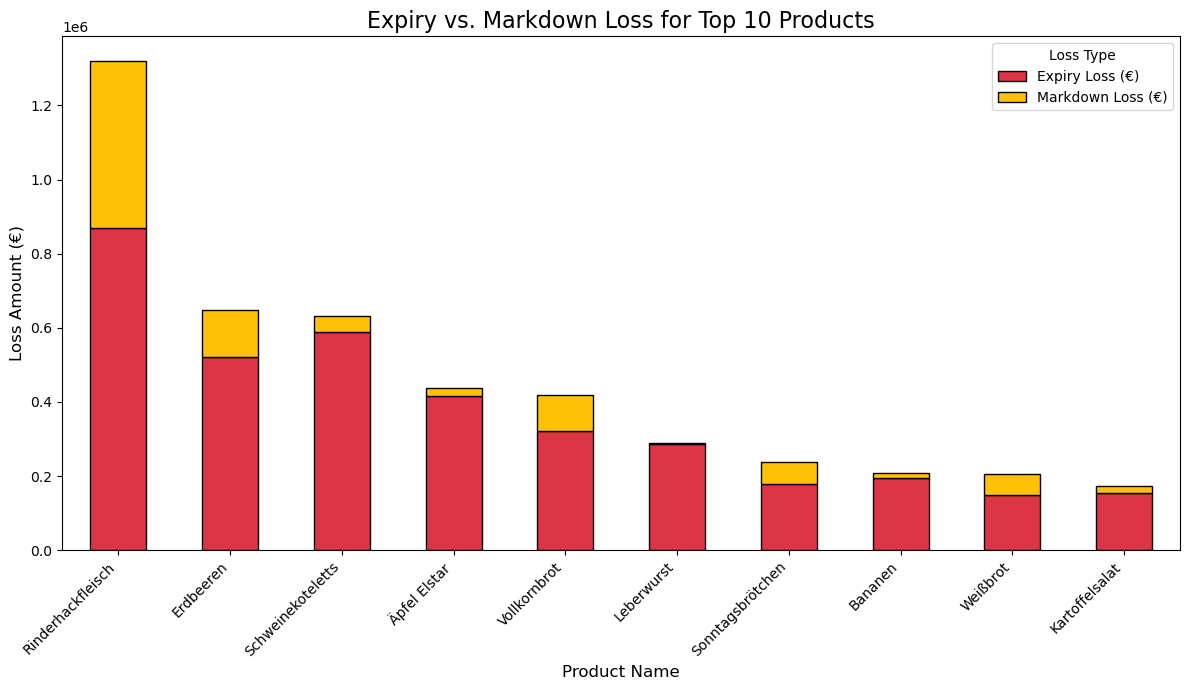

✅ Generated Matplotlib chart for Expiry vs. Markdown Loss for Top 10 Products.


In [86]:
import matplotlib.pyplot as plt # Ensure matplotlib is imported
import seaborn as sns # Ensure seaborn is imported
import pandas as pd # Ensure pandas is imported if not already
import numpy as np # Ensure numpy is imported if not already

# This code assumes 'analysis_df' has been loaded and prepared
# by running the previous cells from the "Overall Loss and Revenue Summary for EDA Notebook" Canvas.

print("\n--- EDA: Expiry vs. Markdown Loss for Top Products ---")

# Step 1: Identify Top N Products by Total Loss (using product_name for aggregation)
N_top_products_for_breakdown = 10 # Define N for the number of top products

# Calculate total expiry, markdown, and overall loss per product name
# Sort by total_overall_loss to get the top products by their combined loss
top_products_total_loss_data = (
    analysis_df.groupby('product_name')
    .agg(
        total_expiry_loss=('expiry_loss_eur', 'sum'),
        total_markdown_loss=('markdown_loss_eur', 'sum'),
        total_overall_loss=('total_loss_eur', 'sum') # Used for sorting
    )
    .sort_values(by='total_overall_loss', ascending=False)
    .head(N_top_products_for_breakdown)
    .reset_index()
)

if not top_products_total_loss_data.empty:
    # Prepare data for stacked bar chart
    # We already have the aggregated data in top_products_total_loss_data
    # The 'loss_driver_df' name from your snippet is not strictly needed if we use this directly.
    # We will use the columns 'total_expiry_loss' and 'total_markdown_loss' from this DataFrame.

    # Set 'product_name' as index for plotting
    plot_data = top_products_total_loss_data.set_index('product_name')

    # Create the stacked bar chart
    plt.figure(figsize=(12, 7)) # Adjust figure size as needed

    # Use Matplotlib's plot.bar() method for stacked bars
    # Define custom colors similar to the Streamlit dashboard for consistency
    colors = {
        'total_expiry_loss': '#DC3545', # Red for expiry
        'total_markdown_loss': '#FFC107' # Yellow/Orange for markdown
    }

    plot_data[['total_expiry_loss', 'total_markdown_loss']].plot(
        kind='bar',
        stacked=True,
        figsize=(12, 7),
        color=[colors['total_expiry_loss'], colors['total_markdown_loss']],
        edgecolor='black', # Add black border to bars
        linewidth=1, # Set linewidth for the border
        ax=plt.gca() # Use current axes
    )

    plt.title(f'Expiry vs. Markdown Loss for Top {N_top_products_for_breakdown} Products', fontsize=16)
    plt.xlabel('Product Name', fontsize=12)
    plt.ylabel('Loss Amount (€)', fontsize=12)
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
    plt.legend(title='Loss Type', labels=['Expiry Loss (€)', 'Markdown Loss (€)']) # Custom legend labels
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show() # Display the chart

    print(f"✅ Generated Matplotlib chart for Expiry vs. Markdown Loss for Top {N_top_products_for_breakdown} Products.")
else:
    print("ℹ️ No data available for Top Products to display Expiry vs. Markdown Loss in the current 'analysis_df' or selected range.")



### Interpretation of "Expiry vs. Markdown Loss for Top Loss Products"

This stacked bar chart breaks down the total loss for the top 10 loss-generating products into two components: `Expiry Loss (€)` (red) and `Markdown Loss (€)` (gold).

**Main Insights:**

* **Expiry is the Dominant Loss Driver:** For all top products, `Expiry Loss (€)` (red bars) constitutes the overwhelming majority of the total loss. This clearly indicates that products are primarily expiring before being sold, even at a discount, leading to significant write-offs.

* **"Rinderhackfleisch" is the Highest Overall Loss Driver:** This product exhibits the highest total loss, with its expiry loss component being particularly substantial (over €800,000). This makes "Rinderhackfleisch" the single largest financial drain due to spoilage.

* **"Erdbeeren" and "Schweinekoteletts" are also Critical High-Loss Items:** Following "Rinderhackfleisch," "Erdbeeren" and "Schweinekoteletts" show the next highest overall losses, with expiry loss also being the predominant factor for both.

**Markdown Loss is a Smaller Component:** While present, `Markdown Loss (€)` (gold portion) is a significantly smaller part of the total loss for all products compared to expiry loss. This suggests that current markdown strategies are only recovering a small portion of the potential value from at-risk inventory.

**Actionable Takeaway for FrischMarkt:**

FrischMarkt's most critical issue is **preventing products from expiring outright.** The current markdown strategies are not effectively converting at-risk inventory into sales to a sufficient degree. The primary focus must be on upstream inventory optimization (better demand forecasting and ordering) to reduce the volume of products that even reach the point of expiry or needing a markdown, especially for "Rinderhackfleisch," "Erdbeeren," and "Schweinekoteletts." Markdown strategies should be re-evaluated to be more aggressive and timely in recouping value from items that are still at risk.

#### Step 3: Investigate Inventory Levels for Top Products

* Why It Matters:
Shows inventory buildup patterns and how they relate to waste events. Useful for diagnosing overstocking or slow-moving SKUs.




--- EDA: Inventory Profiles for Top Loss Products ---


c:\Users\godwi\Downloads\Anconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert in

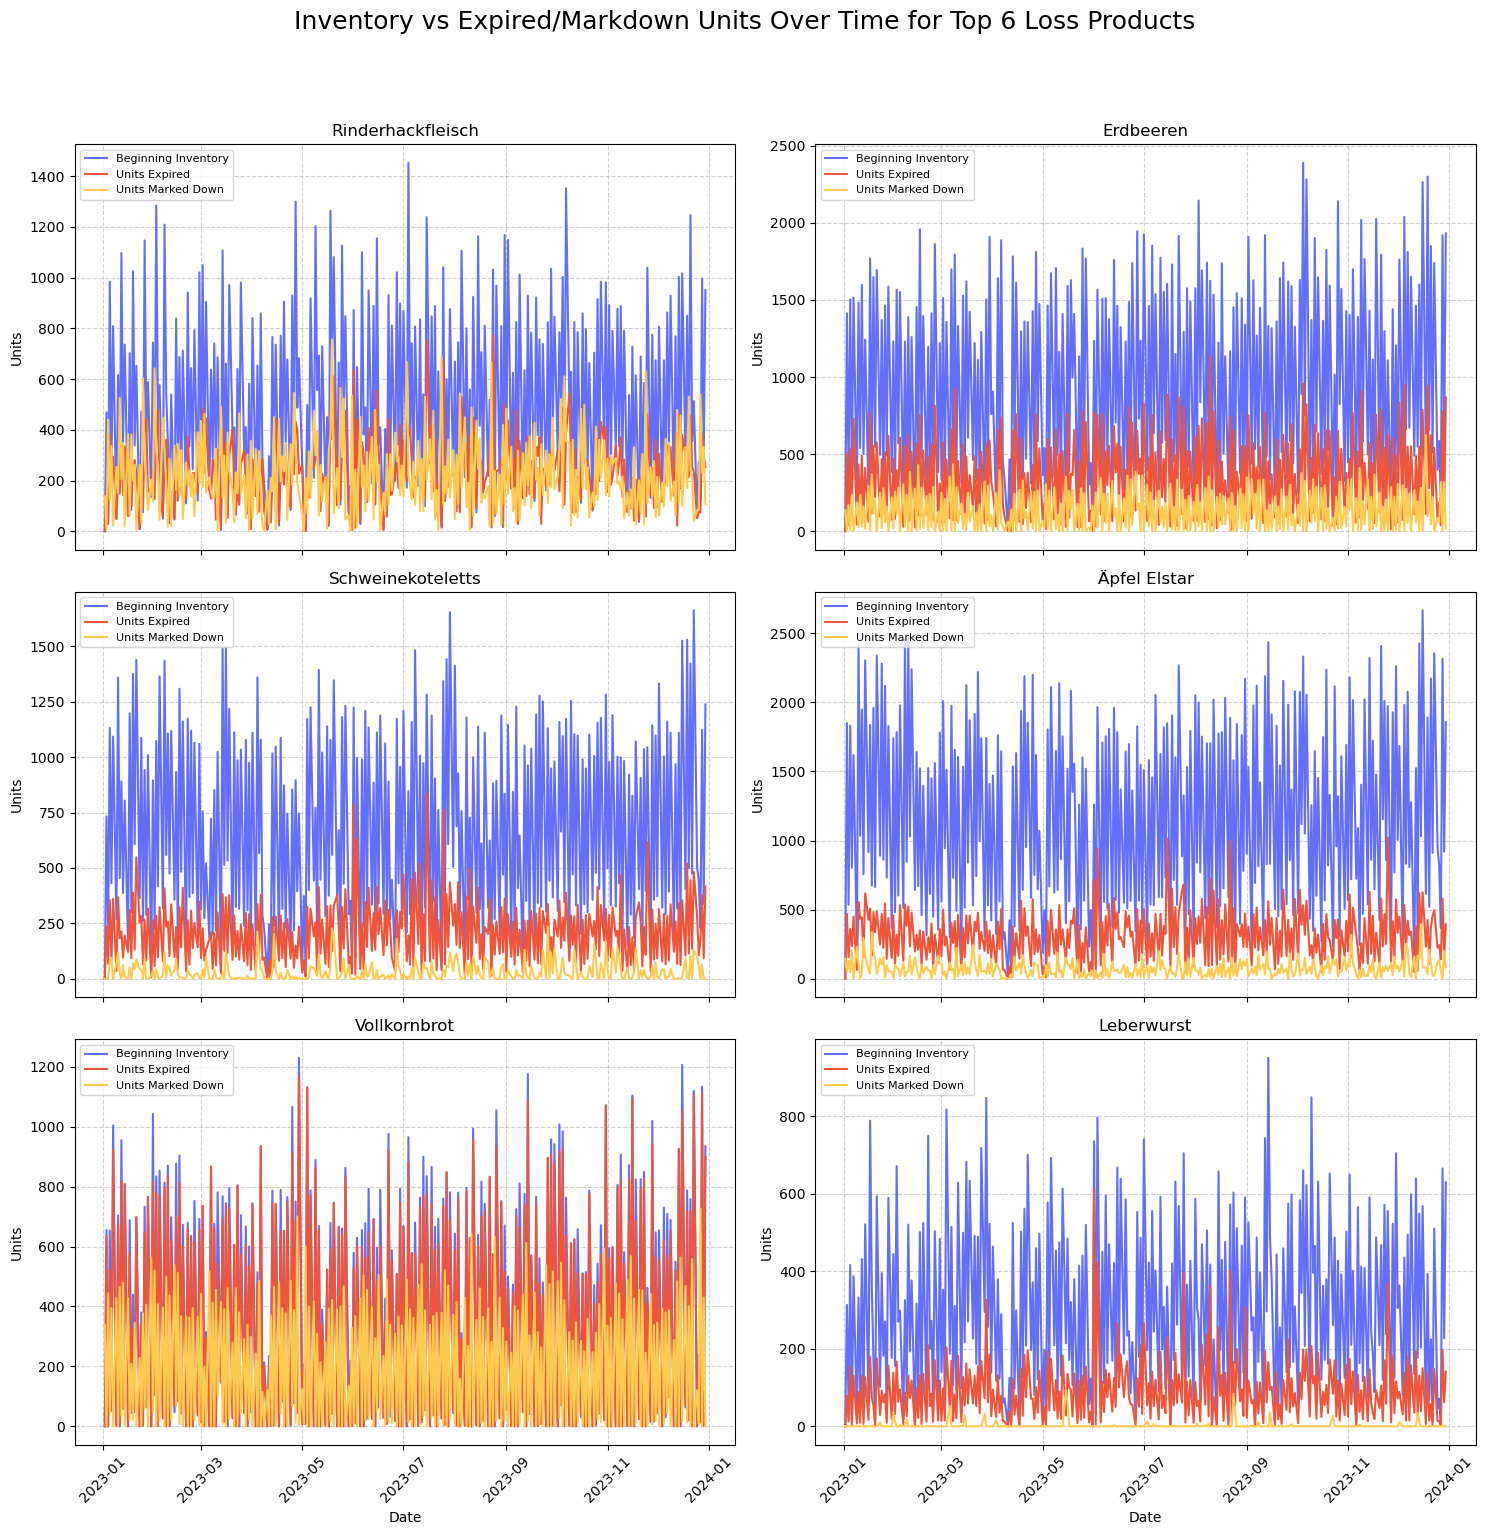

✅ Generated Matplotlib chart for Inventory Profiles of Top 6 Loss Products.


In [87]:
# --- Inventory Profiles for Top Loss Products ---
print("\n--- EDA: Inventory Profiles for Top Loss Products ---")

# Determine the number of top loss products to display for inventory profiles
N_inventory_profiles = 6

# Get the product names of the top N total loss products
top_loss_product_names = (
    analysis_df.groupby('product_name')['total_loss_eur']
    .sum()
    .sort_values(ascending=False)
    .head(N_inventory_profiles)
    .index.tolist()
)

if not top_loss_product_names:
    print("ℹ️ No top loss products found to display inventory profiles.")
else:
    # Get all product_ids that correspond to these top product names
    # This is crucial because one product_name might have multiple product_ids
    top_loss_product_ids_from_names = analysis_df[analysis_df['product_name'].isin(top_loss_product_names)]['product_id'].unique().tolist()

    # Reshape data to long format for plotting multiple metrics with different colors
    inventory_profiles_long = (
        analysis_df[analysis_df['product_id'].isin(top_loss_product_ids_from_names)]
        .groupby(['product_name', 'date'])[['beginning_inventory', 'units_expired', 'units_marked_down']]
        .sum()
        .reset_index()
        .melt(id_vars=['product_name', 'date'], var_name='Metric', value_name='Units')
    )

    # Define a custom palette for clarity, consistent with Streamlit dashboard
    custom_palette = {
        'beginning_inventory': '#636EFA', # Blue
        'units_expired': '#EF553B', # Red
        'units_marked_down': '#FECB52' # Yellow/Orange
    }

    # Create subplots for each top loss product
    num_products = len(top_loss_product_names)
    cols = 2
    rows = (num_products + cols - 1) // cols # Calculate rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), sharex=True)
    axes = axes.flatten() # Flatten array for easy iteration

    for i, product_name in enumerate(top_loss_product_names):
        ax = axes[i]
        product_data = inventory_profiles_long[inventory_profiles_long['product_name'] == product_name]

        for metric in ['beginning_inventory', 'units_expired', 'units_marked_down']:
            metric_data = product_data[product_data['Metric'] == metric]
            sns.lineplot(
                x='date',
                y='Units',
                data=metric_data,
                label=metric.replace('_', ' ').title(),
                color=custom_palette[metric],
                ax=ax
            )
        ax.set_title(f'{product_name}', fontsize=12)
        ax.set_xlabel('Date', fontsize=10)
        ax.set_ylabel('Units', fontsize=10)
        ax.tick_params(axis='x', rotation=45)
        ax.legend(loc='upper left', fontsize=8)
        ax.grid(True, linestyle='--', alpha=0.6)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(f'Inventory vs Expired/Markdown Units Over Time for Top {N_inventory_profiles} Loss Products', fontsize=18, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to make room for suptitle
    plt.show()

    print(f"✅ Generated Matplotlib chart for Inventory Profiles of Top {N_inventory_profiles} Loss Products.")



### Interpretation of "Inventory vs Expired/Markdown Units Over Time for Top Loss Products"

This set of line plots visualizes the daily trends of `Beginning Inventory` (blue), `Units Expired` (red), and `Units Marked Down` (orange) for each of the top 6 loss-generating products.

**Main Insights (General across products):**

1. **High Inventory, High Loss Potential:** The blue lines, representing `Beginning Inventory`, show consistently high and often volatile peaks for all products. These high inventory levels frequently coincide with significant spikes in `Units Expired` (red lines) and `Units Marked Down` (orange lines).

  * **Implication:** This strongly reinforces the finding that overstocking is a primary driver of both expiry and markdown losses. When too much product is on hand, a substantial portion of it either spoils or needs to be discounted.

2. **Expiry Dominates Markdowns:** For most products, the red spikes (`Units Expired`) are generally higher and more frequent than the orange spikes (`Units Marked Down`).

  * **Implication:** This confirms that FrischMarkt is losing more value to outright spoilage than it is recovering through markdowns. The current markdown strategies are not effectively intercepting inventory before it expires.

3. **Product-Specific Patterns:**

  * **"Rinderhackfleisch" (Beef Mince) & "Erdbeeren" (Strawberries):** These two products show particularly high and volatile inventory levels, directly correlating with very large and frequent spikes in expired units. This aligns with their status as top loss generators. The scale of expired units for these products is notably higher than others.

  * **"Schweinekoteletts" (Pork Chops), "Äpfel Elstar" (Elstar Apples), "Vollkornbrot" (Wholemeal Bread), and "Leberwurst" (Liver Sausage):** While their absolute scales of inventory and losses might be lower than "Rinderhackfleisch" and "Erdbeeren," they exhibit similar patterns of high inventory leading to significant expiry and markdown events. The fluctuations in inventory and losses are clearly visible for these items as well.

**Actionable Takeaway for FrischMarkt:**

The visualization provides compelling evidence that **FrischMarkt's core problem lies in over-ordering and inefficient inventory management, leading directly to high expiry.**

* **Implement Demand-Driven Ordering:** The most critical action is to use the demand forecasting model to significantly reduce `Beginning Inventory` levels, especially for top loss products like "Rinderhackfleisch" and "Erdbeeren," to align supply much more closely with actual demand.

* **Proactive Markdown Triggers:** Develop and enforce more proactive and dynamic markdown strategies. Markdowns should be triggered earlier and more effectively to convert at-risk `Beginning Inventory` (blue peaks) into `Units Marked Down` (orange) before they become `Units Expired` (red).

* **Continuous Monitoring:** This type of visualization should be part of a regular monitoring dashboard, allowing managers to quickly identify periods of high inventory correlating with increased losses, prompting immediate corrective action.

## Data Summary

In [88]:
import pandas as pd
import numpy as np
import os # Ensure os is imported if DATA_DIR is used

# --- Ensure DataFrames are loaded and prepared as in Streamlit's load_and_prepare_data ---
# If you haven't run the full data loading and merging sequence in your notebook yet,
# please run the following block first. Otherwise, you can skip it if analysis_df is ready.

# Assuming DATA_DIR is defined, e.g., DATA_DIR = 'frischmarkt_data'
# If not, define it: DATA_DIR = 'frischmarkt_data'

print("--- Ensuring DataFrames for Summary are Ready ---")

try:
    products_df = pd.read_csv(os.path.join(DATA_DIR, 'products_master.csv'))
    stores_df = pd.read_csv(os.path.join(DATA_DIR, 'stores_master.csv'))
    external_df = pd.read_csv(os.path.join(DATA_DIR, 'external_factors.csv'))
    inventory_df = pd.read_csv(os.path.join(DATA_DIR, 'inventory_daily.csv'))
    sales_df = pd.read_csv(os.path.join(DATA_DIR, 'sales_transactions.csv'))
    supplier_df = pd.read_csv(os.path.join(DATA_DIR, 'supplier_performance.csv'))
    print("✅ Raw datasets loaded for summary calculation.")
except FileNotFoundError as e:
    print(f"❌ Error loading data: {e}. Make sure 'frischmarkt_data' directory exists with all CSVs.")
    # You might want to raise an error or exit here if data is critical
    raise

# Convert date columns to datetime objects
for df_temp in [external_df, inventory_df, sales_df]:
    if 'date' in df_temp.columns:
        df_temp['date'] = pd.to_datetime(df_temp['date'])

# Ensure necessary columns are numeric and handle potential NaNs
for col in ['unit_cost', 'retail_price', 'shelf_life_days', 'base_expiry_rate', 'profit_margin']:
    if col in products_df.columns:
        products_df[col] = pd.to_numeric(products_df[col], errors='coerce').fillna(0)

for col in ['beginning_inventory', 'received_inventory', 'units_sold', 'units_expired', 'units_marked_down',
            'expiry_loss_eur', 'markdown_loss_eur', 'total_loss_eur', 'expiry_rate']:
    if col in inventory_df.columns:
        inventory_df[col] = pd.to_numeric(inventory_df[col], errors='coerce').fillna(0)

for col in ['quantity_sold', 'sale_price', 'discount_applied']:
    if col in sales_df.columns:
        sales_df[col] = pd.to_numeric(sales_df[col], errors='coerce').fillna(0)

# --- Data Merging to create 'analysis_df' (as used in Streamlit) ---
analysis_df = inventory_df.merge(products_df, on='product_id', how='left')
analysis_df = analysis_df.merge(stores_df, on='store_id', how='left')
analysis_df = analysis_df.merge(external_df, on=['date', 'store_id'], how='left')

products_with_supplier_df = products_df.merge(supplier_df, on=['product_id', 'supplier_id'], how='left')
products_supplier_agg = products_with_supplier_df.groupby('product_id').agg(
    actual_shelf_life_days=('actual_shelf_life_days', 'mean'),
    delivery_delay_days=('delivery_delay_days', 'mean')
).reset_index()
analysis_df = analysis_df.merge(products_supplier_agg, on='product_id', how='left')

print("✅ 'analysis_df' prepared with all merges, mirroring Streamlit dashboard.")
print(f"Shape of analysis_df: {analysis_df.shape}")

# --- Calculate Overall Loss and Revenue Summary ---
print("\n--- Overall Loss and Revenue Summary (2023) ---")

total_revenue = (sales_df['quantity_sold'] * sales_df['sale_price']).sum()
total_expiry_loss = analysis_df['expiry_loss_eur'].sum()
total_markdown_loss = analysis_df['markdown_loss_eur'].sum()
total_loss = analysis_df['total_loss_eur'].sum()

print(f"Total Revenue: €{total_revenue:,.2f}")
print(f"Total Expiry Loss: €{total_expiry_loss:,.2f}")
print(f"Total Markdown Loss: €{total_markdown_loss:,.2f}")
print(f"Grand Total Loss: €{total_loss:,.2f}")

if total_revenue > 0:
    percentage_loss = (total_loss / total_revenue) * 100
    print(f"Percentage Loss (of Revenue): {percentage_loss:,.2f}%")
else:
    print("Cannot calculate percentage loss: Total Revenue is zero.")

# --- Losses by Product Category ---
print(f"\n--- Losses by Product Category ---")
losses_by_category = analysis_df.groupby('category')['total_loss_eur'].sum().sort_values(ascending=False).reset_index()
print(losses_by_category.to_string(index=False))

# --- Losses by Store ---
print(f"\n--- Losses by Store ---")
losses_by_store = analysis_df.groupby(['store_id', 'store_name'])['total_loss_eur'].sum().sort_values(ascending=False).reset_index()
print(losses_by_store.to_string(index=False))

# --- Top 10 Products by Expiry Loss (aggregated by product_name) ---
print(f"\n--- Top 10 Products by Expiry Loss (by Product Name) ---")
expiry_loss_by_product = analysis_df.groupby('product_name')['expiry_loss_eur'].sum().sort_values(ascending=False).reset_index().head(10)
print(expiry_loss_by_product.to_string(index=False))

# --- Expiry Rates by Management Quality ---
print(f"\n--- Overall Expiry Rate by Management Quality ---")
# Ensure 'beginning_inventory' column is not empty or contains non-numeric values
analysis_df['beginning_inventory_safe'] = analysis_df['beginning_inventory'].replace(0, np.nan)
expiry_rate_by_mgmt = analysis_df.groupby('management_quality').apply(
    lambda x: (x['units_expired'].sum() / x['beginning_inventory_safe'].sum()) if x['beginning_inventory_safe'].sum() > 0 else 0
).reset_index(name='overall_expiry_rate')
expiry_rate_by_mgmt['overall_expiry_rate'] = expiry_rate_by_mgmt['overall_expiry_rate'].apply(lambda x: f"{x:.2%}")
print(expiry_rate_by_mgmt.to_string(index=False))

print("\n✅ Summary calculations complete and printed.")


--- Ensuring DataFrames for Summary are Ready ---
✅ Raw datasets loaded for summary calculation.
✅ 'analysis_df' prepared with all merges, mirroring Streamlit dashboard.
Shape of analysis_df: (67392, 57)

--- Overall Loss and Revenue Summary (2023) ---
Total Revenue: €14,740,876.17
Total Expiry Loss: €4,701,951.56
Total Markdown Loss: €1,077,205.38
Grand Total Loss: €5,779,156.94
Percentage Loss (of Revenue): 39.20%

--- Losses by Product Category ---
        category  total_loss_eur
         Fleisch      2455809.67
      Frischware      1294425.75
       Backwaren      1230559.15
Molkereiprodukte       403633.12
        Feinkost       394729.25

--- Losses by Store ---
store_id                  store_name  total_loss_eur
    S005     FrischMarkt Brandenburg      1128191.91
    S004       FrischMarkt Kreuzberg      1113914.69
    S001 FrischMarkt Prenzlauer Berg       967718.93
    S002 FrischMarkt Prenzlauer Berg       923903.31
    S003       FrischMarkt Kreuzberg       918184.28
   